In [2]:
from estimador import *
from functions import *
from filtros import *
from fit_voc import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

### Obtenemos el Ground Truth de SOH de las celdas

In [3]:
# Obtenemos el ground truth
gt_path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cells_SOH_25deg.csv"
gt_soh_values = pd.read_csv(gt_path)
gt_soh_values

,D30_0,E30_0,F30_0,C85_70,D85_70,D100_85,E100_85,F100_85,D100_0_drive,E100_0_drive,D100_0_,E100_0_
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.956672,0.945440,0.953341,0.978380,0.978223,0.985113,0.987026,0.984339,0.957386,0.952200,0.958063,0.957267
2,0.888100,0.880463,0.888987,0.969021,0.970280,0.965058,0.964104,0.964840,0.934058,0.935481,0.933245,0.934681
3,0.857320,0.851063,0.853256,0.960418,0.962952,0.946165,0.944715,0.946973,0.920934,0.922607,0.908312,0.910992
4,0.841922,0.835265,0.833843,0.953576,0.955763,0.927879,0.927477,0.930778,0.911324,0.912829,0.889487,0.895003
5,0.832690,0.825146,0.824182,0.947506,0.950879,0.913063,0.908689,0.917540,0.902280,0.903161,0.883462,0.886562
6,0.824490,0.814722,0.810584,0.941144,0.942437,0.884896,0.876411,0.896086,0.892396,0.893675,0.876218,0.878436
7,0.818153,0.801828,0.797390,0.937413,0.934023,0.887786,0.888055,0.898636,0.883509,0.884577,0.868952,0.871723
8,0.812961,0.796190,0.791492,0.930387,0.925096,0.857548,0.845812,0.885889,0.875958,0.876944,0.862589,0.865615
9,0.803136,0.781448,0.765043,0.928263,0.919983,0.854349,0.839055,0.881913,0.864434,0.866416,0.855277,0.858361


In [4]:
# Obtenemos los ciclos de cada celda
path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/Datasets/Dataset_aging/cells_cycles_25deg.csv"
cycle_values = pd.read_csv(path)
cycle_values

,D30_0,E30_0,F30_0,C85_70,D85_70,D100_85,E100_85,F100_85,D100_0_drive,E100_0_drive,D100_0_,E100_0_
0,3361,3124,2616,6200,6199,5677,5677,5678,693,703,1170,1171


## Aplicamos el modelo de degradación a cada celda
### Definimos los modelos a utilizar

In [5]:
param = dict(
    vL=1.35531394,
    v0=4.12017677,
    gamma=0.13286143,
    alpha=0.16945463,
    beta=2.34538224,
    Qmax=4.865,
    # Qmax=df.SoH.max(),
    Bias_Rint=0.01454392,
    Factor_Rint=0.1879029,
    life_cycles=938,
    adapt_cell=True,
    degradation_percentage=0.8
)

f_30_0 = FiltrosAnidados()
f_30_0.Q_inst = param.get("Qmax")
f_30_0.fit_batt_model(param)
f_30_0.modelo_th.fit_inverse()
f_30_0.voc_thresh = 0.05
f_30_0.voc_times = 47
f_30_0.sigma_autonomia = 0.04
f_30_0.sigma_capacidad = 0.001 * 5
f_30_0.estim_kwargs = {"sigma_e": 0.00075}

if f_30_0.modelo_th.parameters["adapt_cell"]:
    f_30_0.modelo_th.adapt_degradation()
    f_30_0.modelo_th.setup_knn()
else:
    print("celda: ",f_30_0, "no adaptada")

f_85_70 = FiltrosAnidados()
f_85_70.Q_inst = param.get("Qmax")
f_85_70.fit_batt_model(param)
f_85_70.modelo_th.fit_inverse()
f_85_70.voc_thresh = 0.05
f_85_70.voc_times = 47
f_85_70.sigma_autonomia = 0.04
f_85_70.sigma_capacidad = 0.001 * 5
f_85_70.estim_kwargs = {"sigma_e": 0.00075}

if f_85_70.modelo_th.parameters["adapt_cell"]:
    f_85_70.modelo_th.adapt_degradation()
    f_85_70.modelo_th.setup_knn()
else:
    print("celda: ",f_85_70, "no adaptada")

f_100_85 = FiltrosAnidados()
f_100_85.Q_inst = param.get("Qmax")
f_100_85.fit_batt_model(param)
f_100_85.modelo_th.fit_inverse()
f_100_85.voc_thresh = 0.05
f_100_85.voc_times = 47
f_100_85.sigma_autonomia = 0.04
f_100_85.sigma_capacidad = 0.001 * 5
f_100_85.estim_kwargs = {"sigma_e": 0.00075}

if f_100_85.modelo_th.parameters["adapt_cell"]:
    f_100_85.modelo_th.adapt_degradation()
    f_100_85.modelo_th.setup_knn()
else:
    print("celda: ",f_100_85, "no adaptada")

f_100_0 = FiltrosAnidados()
f_100_0.Q_inst = param.get("Qmax")
f_100_0.fit_batt_model(param)
f_100_0.modelo_th.fit_inverse()
f_100_0.voc_thresh = 0.05
f_100_0.voc_times = 47
f_100_0.sigma_autonomia = 0.04
f_100_0.sigma_capacidad = 0.001 * 5
f_100_0.estim_kwargs = {"sigma_e": 0.00075}

if f_100_0.modelo_th.parameters["adapt_cell"]:
    f_100_0.modelo_th.adapt_degradation()
    f_100_0.modelo_th.setup_knn()
else:
    print("celda: ",f_100_0, "no adaptada")

f_100_0_ = FiltrosAnidados()
f_100_0_.Q_inst = param.get("Qmax")
f_100_0_.fit_batt_model(param)
f_100_0_.modelo_th.fit_inverse()
f_100_0_.voc_thresh = 0.05
f_100_0_.voc_times = 47
f_100_0_.sigma_autonomia = 0.04
f_100_0_.sigma_capacidad = 0.001 * 5
f_100_0_.estim_kwargs = {"sigma_e": 0.00075}

if f_100_0_.modelo_th.parameters["adapt_cell"]:
    f_100_0_.modelo_th.adapt_degradation()
    f_100_0_.modelo_th.setup_knn()
else:
    print("celda: ",f_100_0_, "no adaptada")

# f_maxmin = FiltrosAnidados()
# f_maxmin.Q_inst = param.get("Qmax")
# f_maxmin.fit_batt_model(param)
# f_maxmin.modelo_th.fit_inverse()
# # Ajustamos los parámetros del estimaodor
# f_maxmin.voc_thresh = 0.05
# f_maxmin.voc_times = 47
# f_maxmin.sigma_autonomia = 0.04
# f_maxmin.sigma_capacidad = 0.001 * 5
# f_maxmin.estim_kwargs = {"sigma_e": 0.00075}

# f_subcnom = FiltrosAnidados()
# f_subcnom.Q_inst = param.get("Qmax")
# f_subcnom.fit_batt_model(param)
# f_subcnom.modelo_th.fit_inverse()
# # Ajustamos los parámetros del estimaodor
# f_subcnom.voc_thresh = 0.05
# f_subcnom.voc_times = 47
# f_subcnom.sigma_autonomia = 0.04
# f_subcnom.sigma_capacidad = 0.001 * 5
# f_subcnom.estim_kwargs = {"sigma_e": 0.00075}

# f_subc = FiltrosAnidados()
# f_subc.Q_inst = param.get("Qmax")
# f_subc.fit_batt_model(param)
# f_subc.modelo_th.fit_inverse()
# # Ajustamos los parámetros del estimaodor
# f_subc.voc_thresh = 0.05
# f_subc.voc_times = 47
# f_subc.sigma_autonomia = 0.04
# f_subc.sigma_capacidad = 0.001 * 5
# f_subc.estim_kwargs = {"sigma_e": 0.00075}

modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [1.00000266], '75-0': [1.0000186], '100-50': [0.99999203], '75-25': [1.00001521], '50-0': [1.00002874], '100-75': [1.00002146], '75-50': [1.00000881], '62.5-37.5': [1.0000062], '50-25': [1.00003347], '25-0': [1.00004184]}
Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.01454392,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 0.1879029,
 'Qmax': 4.865,
 'adapt_cell': True,
 'alpha': 0.16945463,
 'beta': 2.34538224,
 'degradation_data': {'100-0': [1.0],
                      '100-25': [1.00000266],
                      '100-50': [0.99999203],
                      '100-75': [1.00002146],
                      '25-0': [1.00004184],
                      '50-0': [1.00002874],
                      '50-25': [1.00003347],
                    

### Ejecutamos el modelo de degradación para cada celda

In [6]:
def degradation_cycle(modelo,cell,SR):
    # asumimos que sabemos el SR de la celda
    cycles = cycle_values[cell]
    # calculamos el eta para ese ciclo
    etak = eta_subciclo(SR, modelo)
    EOL = etak**cycles
    return EOL

In [7]:
cells = ["D30_0","D85_70","D100_85","D100_0_drive","D100_0_"]
models = [f_30_0,f_85_70,f_100_85,f_100_0,f_100_0_]
SR = [[30,0],[85,70],[100,85],[100,0],[100,0]]

SOH_calculado = []
for i,cell in enumerate(cells):
    soh = degradation_cycle(models[i],cell,SR[i])
    soh = soh.values[0]
    SOH_calculado.append(soh)
SOH_calculado

eta0:  0.9997621353824262  etak:  [0.99974015]  normalizado a:  [0.99992204]  para subciclo:  [30, 0]
calculo para subciclo:  [30, 0] eta =  [0.99992204]
eta0:  0.9997621353824262  etak:  [0.99928463]  normalizado a:  [0.99989266]  para subciclo:  [85, 70]
calculo para subciclo:  [85, 70] eta =  [0.99989266]
eta0:  0.9997621353824262  etak:  [0.99937542]  normalizado a:  [0.99990629]  para subciclo:  [100, 85]
calculo para subciclo:  [100, 85] eta =  [0.99990629]
eta0:  0.9997621353824262  etak:  [0.999762]  normalizado a:  [0.999762]  para subciclo:  [100, 0]
calculo para subciclo:  [100, 0] eta =  [0.999762]
eta0:  0.9997621353824262  etak:  [0.999762]  normalizado a:  [0.999762]  para subciclo:  [100, 0]
calculo para subciclo:  [100, 0] eta =  [0.999762]


[0.7694765171627983,
 0.5140540373754491,
 0.5874125150927407,
 0.8479338733669566,
 0.7569247424012531]

In [8]:
gt_soh_values_ = gt_soh_values[cells]
ones_list = [1 for _ in range(5)]

# Initialize an empty list to store interpolated values for each column
interpolated_values = []

# Iterate through each column
for i in range(len(SOH_calculado)):
    # Linearly interpolate between 1 and the corresponding value in soh_list
    interpolated_column = np.linspace(1, SOH_calculado[i], gt_soh_values_[cells[i]].count())

    desired_size = 16

    # If the array is smaller than the desired size, fill with NaN values
    if len(interpolated_column) < desired_size:
        filled_array = np.pad(interpolated_column, (0, desired_size - len(interpolated_column)), mode='constant', constant_values=np.nan)
    else:
        filled_array = interpolated_column

    interpolated_values.append(filled_array)

# Stack the ones list and the interpolated values horizontally to create the matrix
# result_matrix = np.hstack((ones_list, np.array(interpolated_values).T))
# Define the desired size
interpolated_values

[array([1.        , 0.98226742, 0.96453485, 0.94680227, 0.9290697 ,
        0.91133712, 0.89360455, 0.87587197, 0.8581394 , 0.84040682,
        0.82267424, 0.80494167, 0.78720909, 0.76947652,        nan,
               nan]),
 array([1.        , 0.9595045 , 0.91900901, 0.87851351, 0.83801801,
        0.79752252, 0.75702702, 0.71653152, 0.67603602, 0.63554053,
        0.59504503, 0.55454953, 0.51405404,        nan,        nan,
               nan]),
 array([1.        , 0.96249205, 0.92498409, 0.88747614, 0.84996819,
        0.81246023, 0.77495228, 0.73744433, 0.69993637, 0.66242842,
        0.62492047, 0.58741252,        nan,        nan,        nan,
               nan]),
 array([1.        , 0.98310376, 0.96620753, 0.94931129, 0.93241505,
        0.91551882, 0.89862258, 0.88172635, 0.86483011, 0.84793387,
               nan,        nan,        nan,        nan,        nan,
               nan]),
 array([1.        , 0.98379498, 0.96758997, 0.95138495, 0.93517993,
        0.91897491, 0.902769

### Graficamos los valores

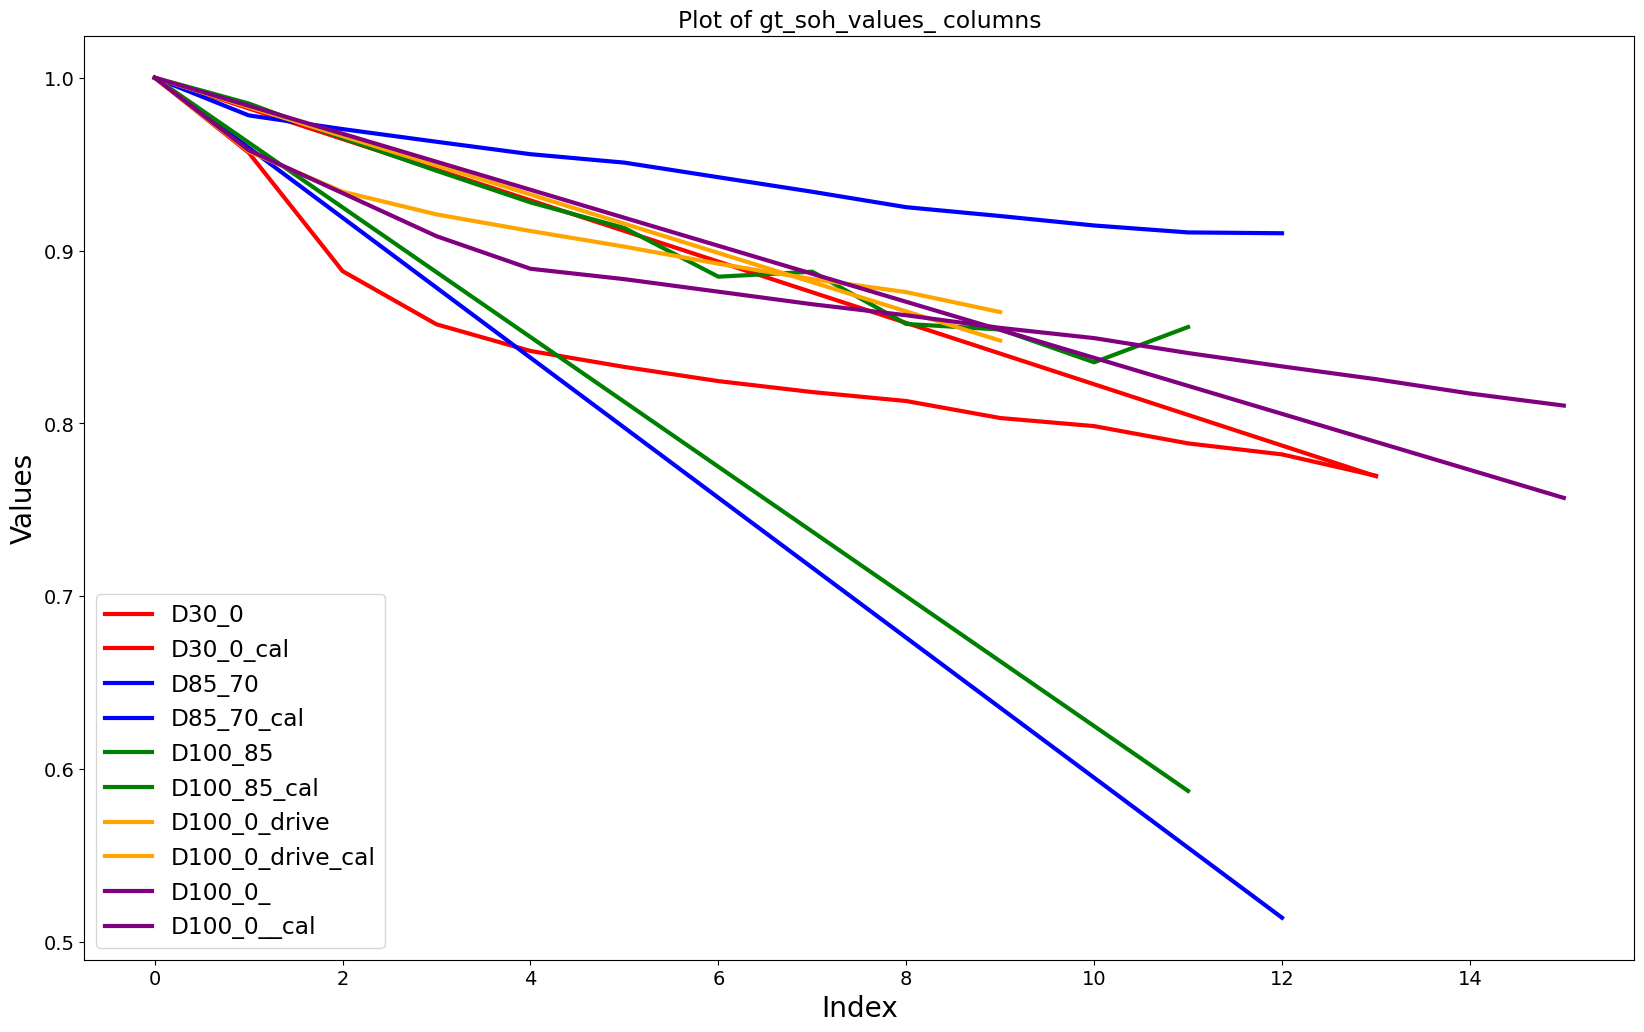

In [9]:
colors = ['red', 'blue', 'green', 'orange', 'purple']

plt.figure(figsize=(20, 12))

for i,column in enumerate(gt_soh_values_.columns):
    plt.plot(gt_soh_values_.index, gt_soh_values_[column], label=column,color=colors[i])
    plt.plot(gt_soh_values_.index, interpolated_values[i], label=column+'_cal',color=colors[i])

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of gt_soh_values_ columns')
plt.legend()
plt.show()

In [20]:
interpolated_values[cells.index("D100_0_drive")]

array([1.        , 0.98310376, 0.96620753, 0.94931129, 0.93241505,
       0.91551882, 0.89862258, 0.88172635, 0.86483011, 0.84793387,
              nan,        nan,        nan,        nan,        nan,
              nan])

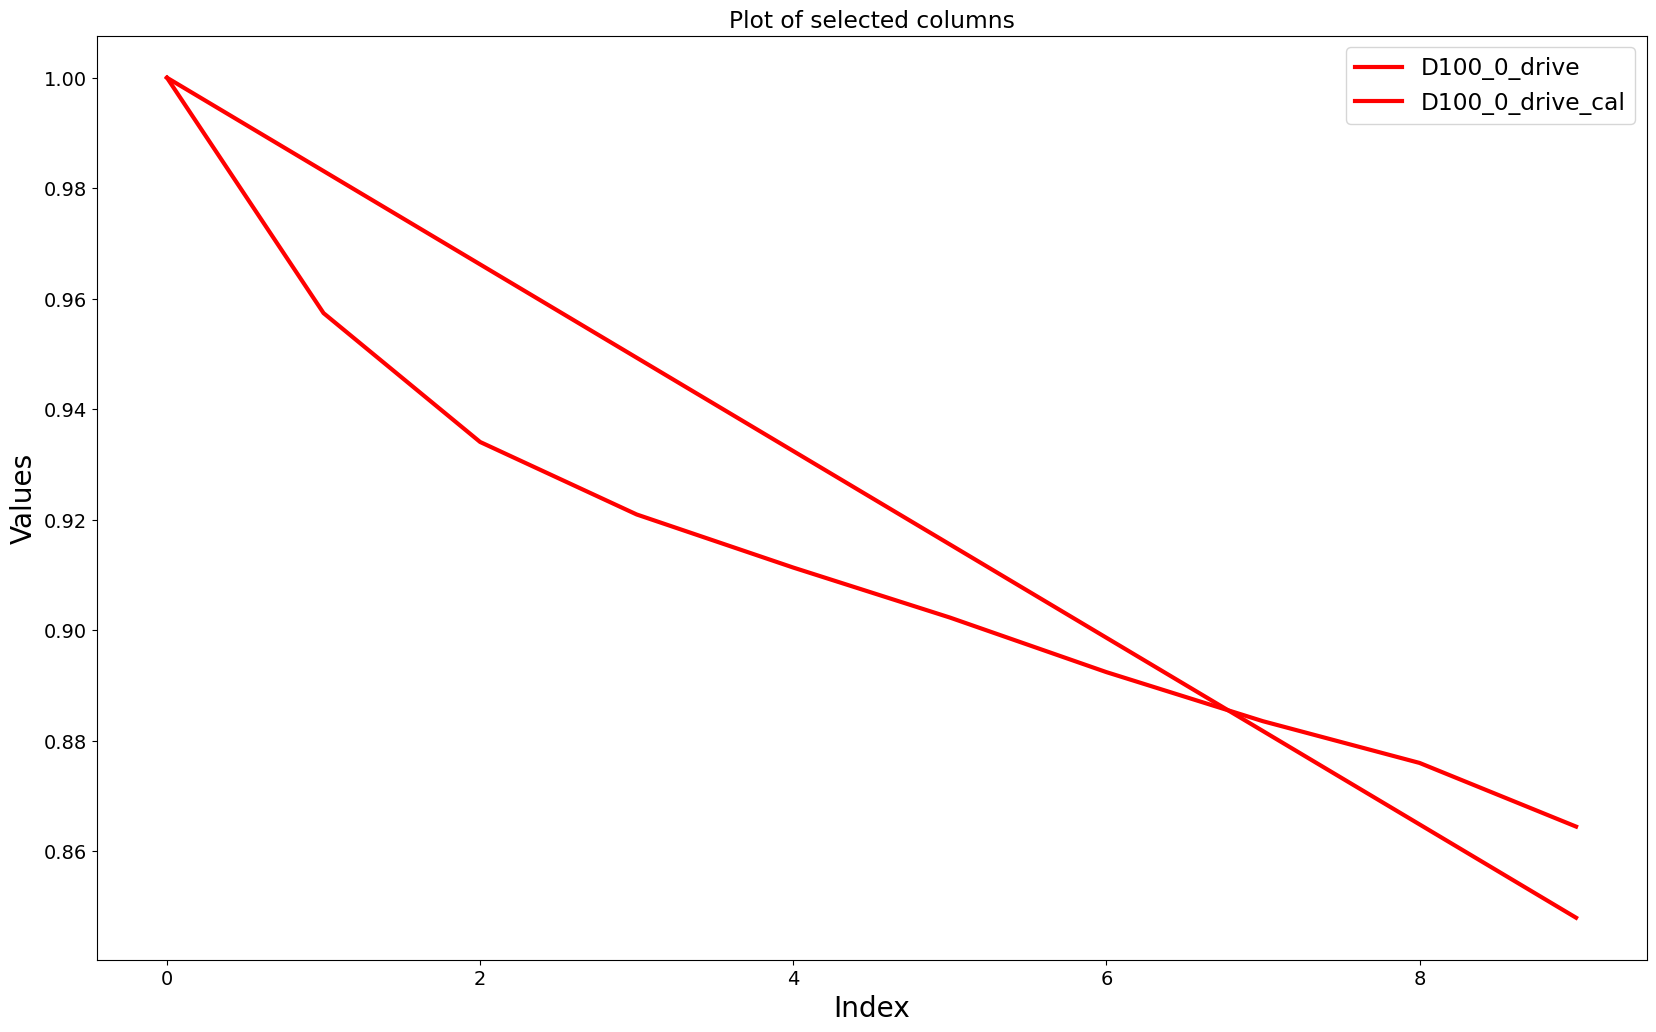

In [27]:
cells = ["D30_0","D85_70","D100_85","D100_0_drive","D100_0_"]
selected_columns = ["D100_0_drive"]
plt.figure(figsize=(20, 12))

for i, column in enumerate(selected_columns):
    plt.plot(gt_soh_values_.index, gt_soh_values_[column], label=column, color=colors[i])
    plt.plot(gt_soh_values_.index, interpolated_values[cells.index(column)], label=column+'_cal', color=colors[i])

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of selected columns')
plt.legend()
plt.show()